# Going from simple linear regression with one variable to pytorch
<i>Referenced from the book "Deep Learning with PyTorch Step-by-Step" by Daniel Voigt  </i>

## Numpy Linear Regression Blitz

In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)    #numpy.random.seed function provides the input (i.e., the seed) to the algorithm that generates pseudo-random numbers in NumPy.
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)


In [29]:
idx = np.arange(100)
print(idx[:5])
np.random.shuffle(idx)

[0 1 2 3 4]


In [30]:
train_idx = idx[:80]
val_idx = idx[80:]

x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = y[val_idx], y[val_idx]

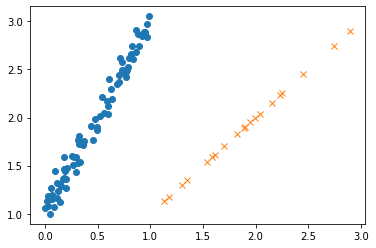

In [31]:
plt.plot(x_train, y_train,'o')
plt.plot(x_test, y_test,'x')

## Two main init steps for training a model
<ol> 
        <li> Random initialize parameters or weights </li>
        <li> Init hyperparameters (epochs, learning rate)
    </ol>

In [32]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)


print(a, b)

[0.49671415] [-0.1382643]


In [33]:
# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

In [34]:
for epoch in range(n_epochs):
    yhat = a + b * x_train
    error = y_train - yhat
    loss =(error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

[1.02354094] [1.96896411]


### Confirm that the results are correct using sklearn

In [35]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.02354075] [1.96896447]


# Torch it up

In [36]:
!pip install torchviz

In [37]:
import torch 
import torch.optim as optim   #to update weights when dealing with tensors
import torch.nn as nn         #for creating PyTorch models
from torchviz import make_dot #vizualize the computation graph

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [39]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [40]:
for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
#     print('a',a.grad)
#     print('b',b.grad)
    
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
print(a,b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


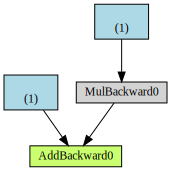

In [41]:
from torchviz import make_dot
make_dot(yhat)

In [42]:
lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
# with torch.no_grad():
#     a -= lr * a.grad
#     b -= lr * b.grad
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # DEFINE LOSS FUNCTION
    #error = y_train_tensor - yhat
    #loss = (error ** 2).mean()
    loss_fn = nn.MSELoss(reduction='mean')
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Observe that the weights are same as what we got before when we performed linear regression with numpy. Sanity check to confirm that we have used pytorch corrrectly.